In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
%matplotlib inline

import itertools
from kernels import HMC_our, HMC_vanilla, Reverse_kernel_sampling
from target import GMM_target, GMM_target2, Funnel, Gaussian_target
from args import get_args

import matplotlib
matplotlib.rcParams.update({'font.size': 20})

import pdb

In [2]:
args = get_args()

In [3]:
target = GMM_target(args)

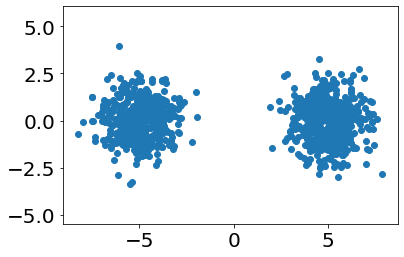

In [4]:
target_samples = target.get_samples(n=1000).cpu().numpy()
plt.scatter(target_samples[:, 0], target_samples[:, 1])
plt.axis('equal');

#### Common setup

In [5]:
args.n_steps = 1000 # how many samples to use
args.n_warmup = 1000 # num of first samples to refuse

args.n_chains = 10 # how many chains to model
args.optimize_init_params = False
args.data_dim = 2

In [6]:
if args.optimize_init_params:
    mu_init = nn.Parameter(torch.zeros(args.data_dim, device=args.device, dtype=args.torchType))
    sigma_init = nn.Parameter(torch.eye(args.data_dim, device=args.device, dtype=args.torchType).squeeze())
    init_distr = torch.distributions.Normal(loc=mu_init, scale=sigma_init)

#### Vanilla HMC

In [7]:
vanilla_kernel = HMC_vanilla(args)

In [8]:
if args.optimize_init_params:
    optimizer = torch.optim.Adam(params=[mu_init, sigma_init])
    for i in tqdm(range(5000)):
        q_init = init_distr.sample((500, ))
        current_kl = init_distr.log_prob(q_init) - target.get_logdensity(z=q_init)
        torch.mean(-current_kl).backward()
        optimizer.step()
        init_distr = torch.distributions.MultivariateNormal(loc=mu_init, covariance_matrix=sigma_init)
        if i % 500 == 0:
            print(current_kl.mean().cpu().detach().numpy())

if args.optimize_init_params:
    q_new = init_distr.sample((args.n_chains, ))
else:
    q_new = args.std_normal.sample((args.n_chains, args.z_dim))
p_init = args.std_normal.sample((args.n_chains, args.z_dim))
p_new = p_init
q_new = q_init
        
print("Now we are running warmup!")
iterator = tqdm(range(args.n_warmup))
for i in iterator:
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
iterator.close()
    
samples_vanilla = torch.empty((args.n_steps, args.n_chains, args.z_dim), device=args.device, dtype=args.torchType)
print("Now we are sampling!")

iterator = tqdm(range(args.n_steps))
for i in iterator:
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
    samples_vanilla[i] = q_new
iterator.close()

NameError: name 'q_init' is not defined

NameError: name 'samples_vanilla' is not defined

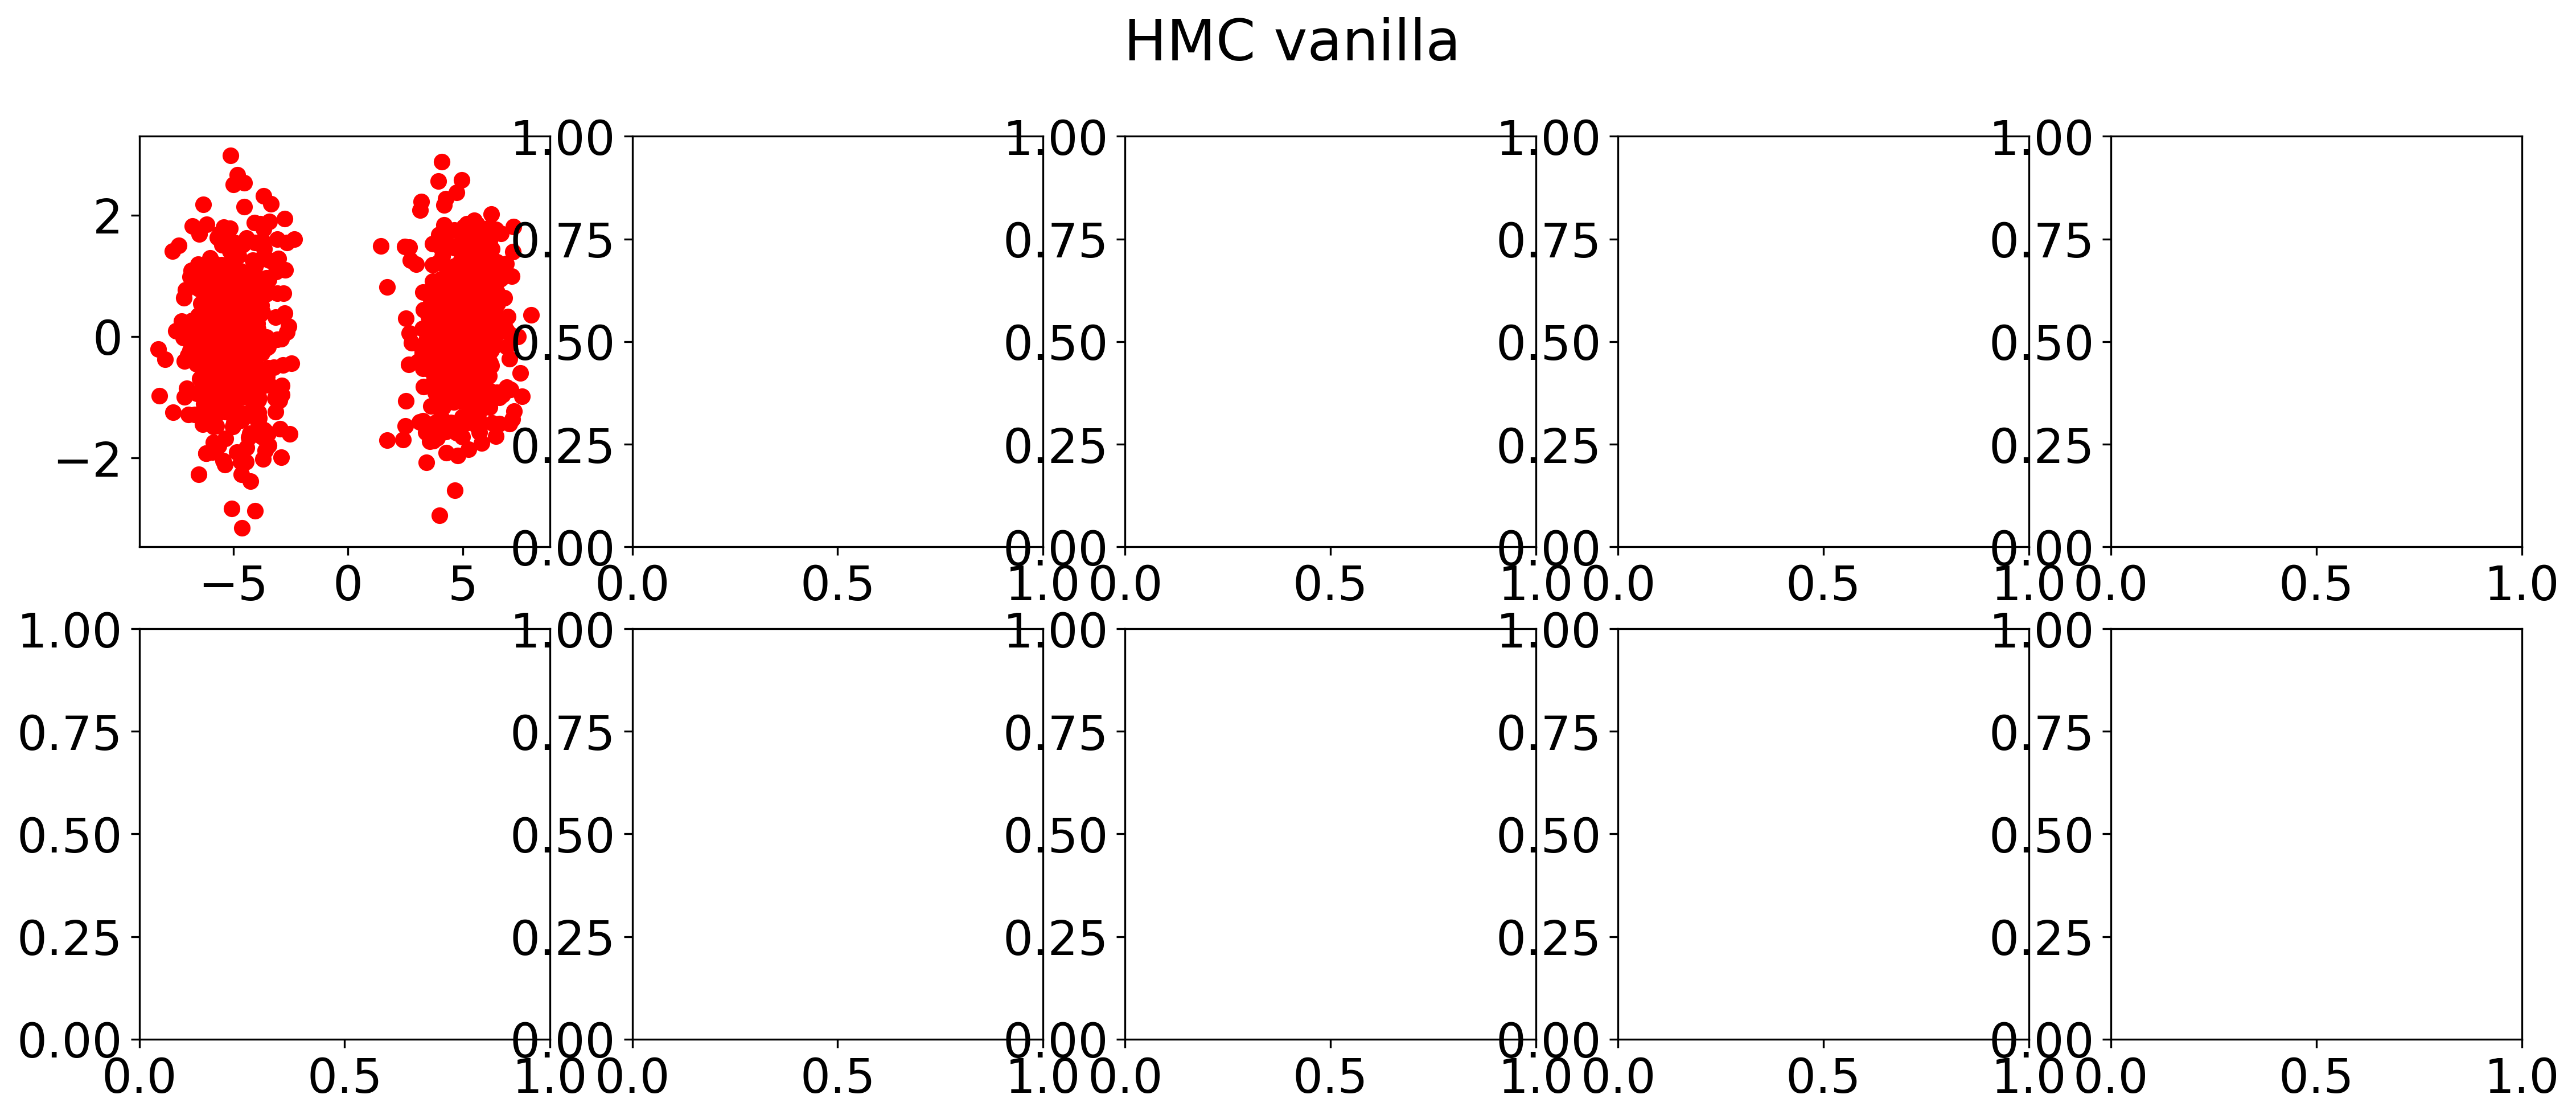

In [15]:
limit = 30
fig, ax = plt.subplots(nrows=args.n_chains // 5, ncols=5, figsize=(18, 7), dpi=300)
plt.suptitle('HMC vanilla')
for chain_num in range(args.n_chains):
    ax[chain_num // 5, chain_num % 5].scatter(target_samples[:, 0], target_samples[:, 1], c='r', label='Target')
    ax[chain_num // 5, chain_num % 5].scatter(samples_vanilla[:, chain_num, 0].cpu(), samples_vanilla[:, chain_num, 1].cpu(), label='Result')
    ax[chain_num // 5, chain_num % 5].set_xlim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_ylim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_aspect('equal')
    ax[chain_num // 5, chain_num % 5].legend()
plt.tight_layout();
plt.subplots_adjust(left=0., right=1., bottom=0., top=0.9, wspace=0.1, hspace=0.15)

#### Ours HMC

In [6]:
if args.learnable_reverse:
    reverse_kernel = Reverse_kernel_sampling(kwargs=args).to(args.device)
    reverse_params = reverse_kernel.parameters()
else:
    reverse_params = list([])
    
transitions = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args.K)])
our_kernel = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args.K)])

params = list(transitions.parameters()) + list(reverse_params)

optimizer = torch.optim.Adam(params=params)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=200, factor=0.9)

limit = 30

##### Training

  0%|          | 0/5000 [00:00<?, ?it/s]

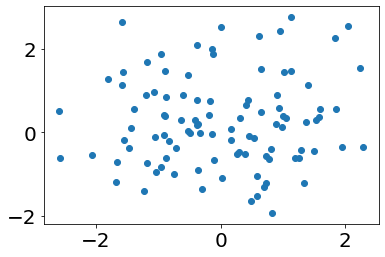

  0%|          | 3/5000 [00:00<10:42,  7.78it/s]

Current lr:  0.001
On batch number 0 ELBO is -15.617891311645508
On batch number 0 Best ELBO is -inf


  2%|▏         | 99/5000 [00:06<04:58, 16.42it/s]

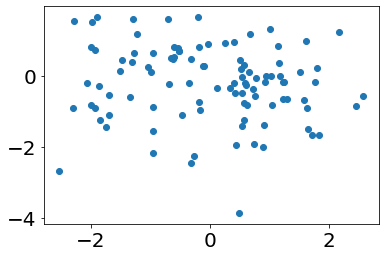

  2%|▏         | 103/5000 [00:06<05:46, 14.13it/s]

Current lr:  0.001
On batch number 100 ELBO is -16.37244987487793
On batch number 100 Best ELBO is -13.87994384765625


  4%|▍         | 199/5000 [00:12<04:46, 16.75it/s]

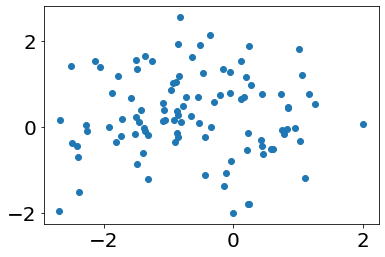

  4%|▍         | 203/5000 [00:12<05:34, 14.36it/s]

Current lr:  0.001
On batch number 200 ELBO is -14.597795486450195
On batch number 200 Best ELBO is -13.281076431274414


  6%|▌         | 299/5000 [00:18<04:41, 16.70it/s]

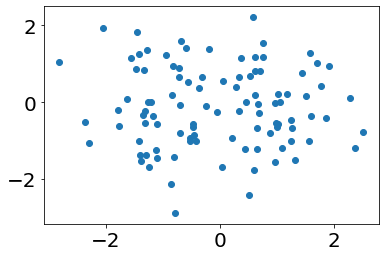

  6%|▌         | 303/5000 [00:18<05:28, 14.31it/s]

Current lr:  0.001
On batch number 300 ELBO is -14.03042221069336
On batch number 300 Best ELBO is -12.814184188842773


  8%|▊         | 399/5000 [00:24<04:35, 16.72it/s]

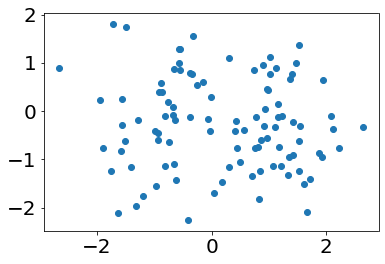

  8%|▊         | 403/5000 [00:24<05:37, 13.62it/s]

Current lr:  0.001
On batch number 400 ELBO is -12.74248218536377
On batch number 400 Best ELBO is -12.272396087646484


 10%|▉         | 499/5000 [00:30<04:28, 16.75it/s]

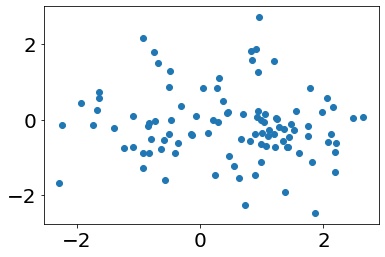

 10%|█         | 503/5000 [00:30<05:13, 14.35it/s]

Current lr:  0.001
On batch number 500 ELBO is -13.773117065429688
On batch number 500 Best ELBO is -11.871740341186523


 12%|█▏        | 599/5000 [00:36<04:22, 16.75it/s]

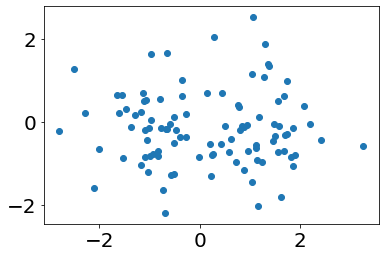

 12%|█▏        | 603/5000 [00:36<05:05, 14.38it/s]

Current lr:  0.001
On batch number 600 ELBO is -11.91281509399414
On batch number 600 Best ELBO is -11.806974411010742


 14%|█▍        | 699/5000 [00:42<04:17, 16.72it/s]

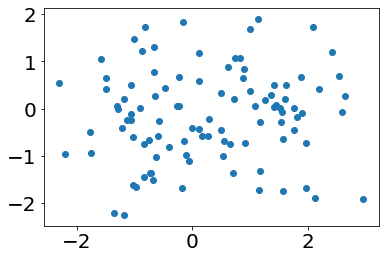

 14%|█▍        | 703/5000 [00:42<05:01, 14.25it/s]

Current lr:  0.001
On batch number 700 ELBO is -11.858049392700195
On batch number 700 Best ELBO is -11.087570190429688


 16%|█▌        | 799/5000 [00:48<04:11, 16.69it/s]

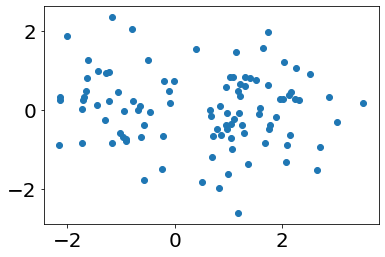

 16%|█▌        | 803/5000 [00:49<04:53, 14.29it/s]

Current lr:  0.001
On batch number 800 ELBO is -11.126107215881348
On batch number 800 Best ELBO is -10.375407218933105


 18%|█▊        | 899/5000 [00:54<04:05, 16.69it/s]

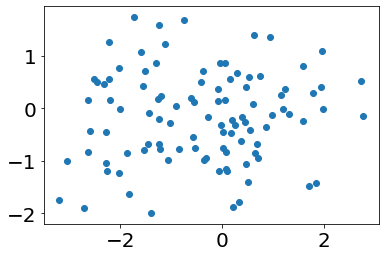

 18%|█▊        | 903/5000 [00:55<05:07, 13.34it/s]

Current lr:  0.001
On batch number 900 ELBO is -11.83857536315918
On batch number 900 Best ELBO is -10.281142234802246


 20%|█▉        | 999/5000 [01:00<03:59, 16.74it/s]

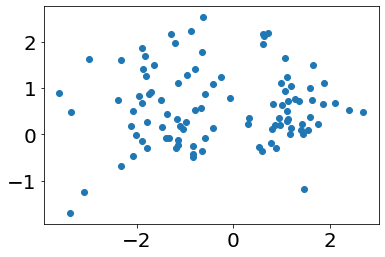

 20%|██        | 1003/5000 [01:01<04:38, 14.34it/s]

Current lr:  0.001
On batch number 1000 ELBO is -11.333845138549805
On batch number 1000 Best ELBO is -9.733155250549316


 22%|██▏       | 1099/5000 [01:07<03:59, 16.28it/s]

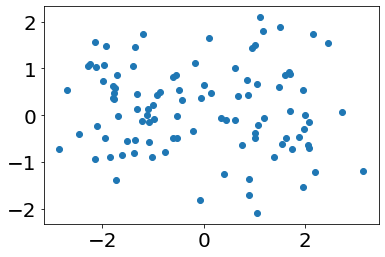

 22%|██▏       | 1103/5000 [01:07<04:40, 13.91it/s]

Current lr:  0.001
On batch number 1100 ELBO is -10.167624473571777
On batch number 1100 Best ELBO is -9.646958351135254


 24%|██▍       | 1199/5000 [01:13<03:48, 16.63it/s]

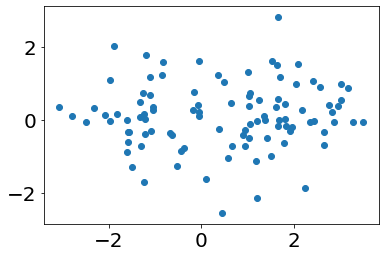

 24%|██▍       | 1203/5000 [01:13<04:25, 14.29it/s]

Current lr:  0.001
On batch number 1200 ELBO is -9.972946166992188
On batch number 1200 Best ELBO is -8.960930824279785


 26%|██▌       | 1299/5000 [01:19<03:42, 16.63it/s]

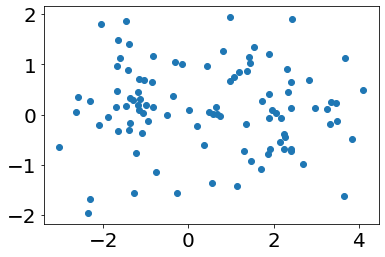

 26%|██▌       | 1303/5000 [01:19<04:20, 14.17it/s]

Current lr:  0.001
On batch number 1300 ELBO is -9.27375316619873
On batch number 1300 Best ELBO is -8.435513496398926


 28%|██▊       | 1399/5000 [01:25<03:36, 16.61it/s]

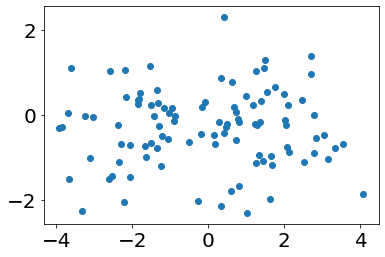

 28%|██▊       | 1403/5000 [01:25<04:13, 14.18it/s]

Current lr:  0.001
On batch number 1400 ELBO is -8.557286262512207
On batch number 1400 Best ELBO is -8.064854621887207


 30%|██▉       | 1499/5000 [01:31<03:32, 16.46it/s]

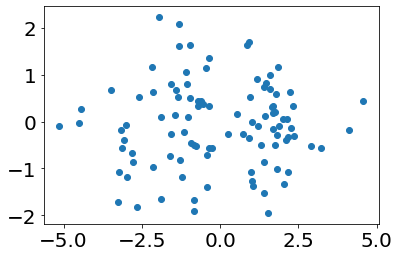

 30%|███       | 1503/5000 [01:31<04:23, 13.27it/s]

Current lr:  0.001
On batch number 1500 ELBO is -8.65042781829834
On batch number 1500 Best ELBO is -7.827126502990723


 32%|███▏      | 1599/5000 [01:37<03:26, 16.43it/s]

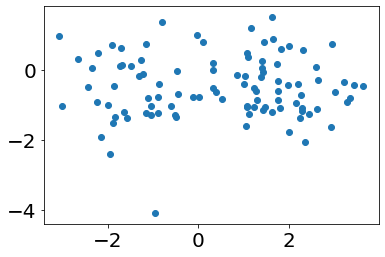

 32%|███▏      | 1603/5000 [01:38<04:01, 14.09it/s]

Current lr:  0.001
On batch number 1600 ELBO is -9.219888687133789
On batch number 1600 Best ELBO is -7.663918495178223


 34%|███▍      | 1699/5000 [01:43<03:20, 16.46it/s]

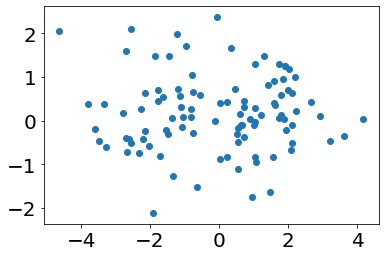

 34%|███▍      | 1703/5000 [01:44<03:55, 14.02it/s]

Current lr:  0.001
On batch number 1700 ELBO is -9.361053466796875
On batch number 1700 Best ELBO is -7.663918495178223


 36%|███▌      | 1799/5000 [01:50<03:14, 16.48it/s]

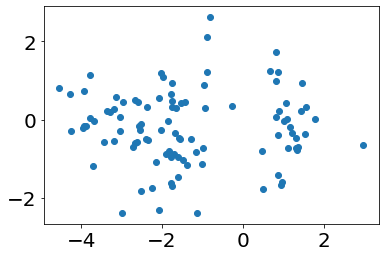

 36%|███▌      | 1803/5000 [01:50<03:46, 14.13it/s]

Current lr:  0.001
On batch number 1800 ELBO is -8.513378143310547
On batch number 1800 Best ELBO is -7.5238566398620605


 38%|███▊      | 1899/5000 [01:56<03:08, 16.47it/s]

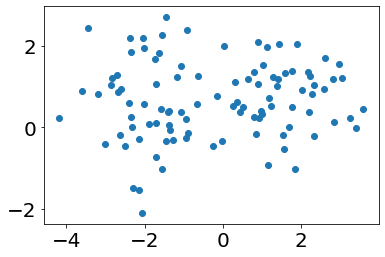

 38%|███▊      | 1903/5000 [01:56<03:39, 14.12it/s]

Current lr:  0.001
On batch number 1900 ELBO is -8.800872802734375
On batch number 1900 Best ELBO is -7.5238566398620605


 40%|███▉      | 1999/5000 [02:02<03:30, 14.28it/s]

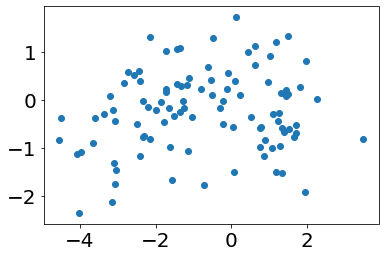

 40%|████      | 2003/5000 [02:03<04:08, 12.04it/s]

Current lr:  0.0009000000000000001
On batch number 2000 ELBO is -9.026123046875
On batch number 2000 Best ELBO is -7.5238566398620605


 42%|████▏     | 2099/5000 [02:09<03:18, 14.62it/s]

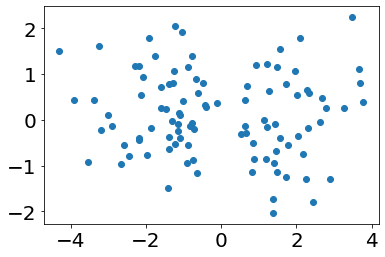

 42%|████▏     | 2103/5000 [02:10<03:51, 12.50it/s]

Current lr:  0.0009000000000000001
On batch number 2100 ELBO is -8.726916313171387
On batch number 2100 Best ELBO is -7.5238566398620605


 44%|████▍     | 2199/5000 [02:16<03:15, 14.32it/s]

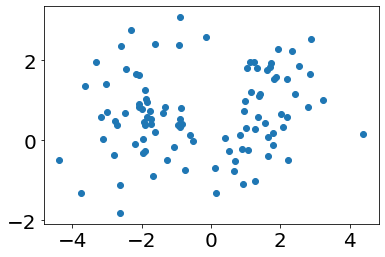

 44%|████▍     | 2203/5000 [02:17<03:48, 12.23it/s]

Current lr:  0.0009000000000000001
On batch number 2200 ELBO is -8.90761661529541
On batch number 2200 Best ELBO is -7.376094341278076


 46%|████▌     | 2299/5000 [02:24<03:06, 14.46it/s]

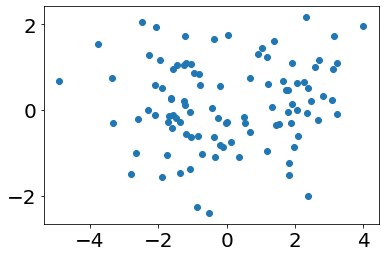

 46%|████▌     | 2303/5000 [02:24<03:38, 12.36it/s]

Current lr:  0.0009000000000000001
On batch number 2300 ELBO is -8.931694030761719
On batch number 2300 Best ELBO is -7.332570552825928


 48%|████▊     | 2399/5000 [02:31<03:03, 14.14it/s]

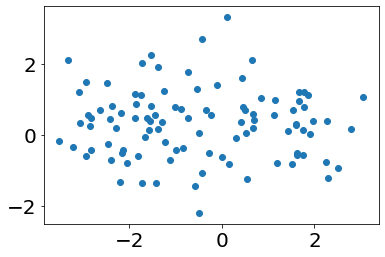

 48%|████▊     | 2403/5000 [02:31<03:31, 12.30it/s]

Current lr:  0.0009000000000000001
On batch number 2400 ELBO is -9.131585121154785
On batch number 2400 Best ELBO is -7.269956111907959


 50%|████▉     | 2499/5000 [02:38<02:50, 14.71it/s]

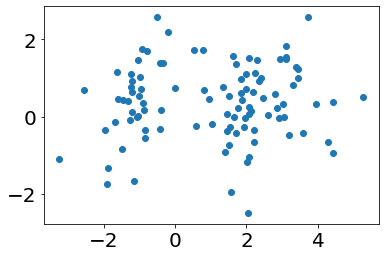

 50%|█████     | 2503/5000 [02:38<03:15, 12.74it/s]

Current lr:  0.0009000000000000001
On batch number 2500 ELBO is -8.774810791015625
On batch number 2500 Best ELBO is -7.269956111907959


 52%|█████▏    | 2599/5000 [02:45<02:43, 14.72it/s]

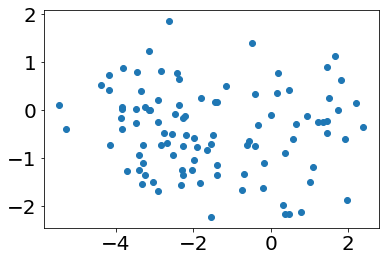

 52%|█████▏    | 2603/5000 [02:45<03:18, 12.11it/s]

Current lr:  0.0008100000000000001
On batch number 2600 ELBO is -8.86255931854248
On batch number 2600 Best ELBO is -7.269956111907959


 54%|█████▍    | 2699/5000 [02:52<02:39, 14.44it/s]

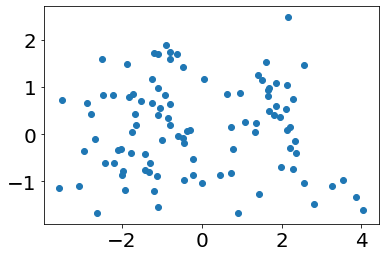

 54%|█████▍    | 2703/5000 [02:52<02:59, 12.80it/s]

Current lr:  0.0008100000000000001
On batch number 2700 ELBO is -8.676480293273926
On batch number 2700 Best ELBO is -7.269956111907959


 56%|█████▌    | 2799/5000 [02:59<02:32, 14.48it/s]

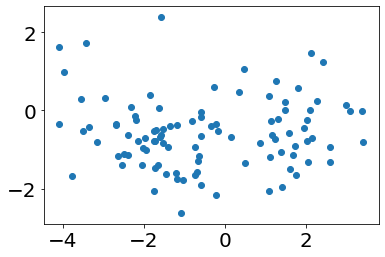

 56%|█████▌    | 2803/5000 [02:59<02:55, 12.54it/s]

Current lr:  0.000729
On batch number 2800 ELBO is -8.291741371154785
On batch number 2800 Best ELBO is -7.238753318786621


 58%|█████▊    | 2899/5000 [03:06<02:25, 14.45it/s]

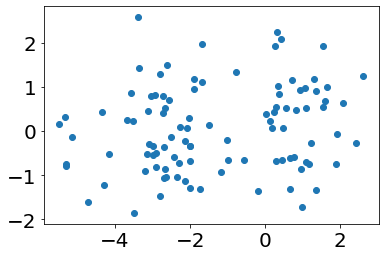

 58%|█████▊    | 2903/5000 [03:06<02:47, 12.52it/s]

Current lr:  0.000729
On batch number 2900 ELBO is -8.133256912231445
On batch number 2900 Best ELBO is -7.238753318786621


 60%|█████▉    | 2999/5000 [03:13<02:19, 14.35it/s]

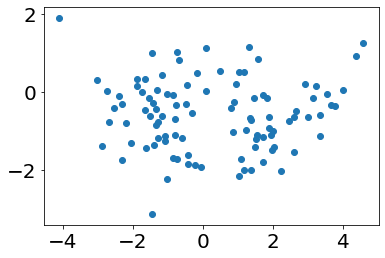

 60%|██████    | 3003/5000 [03:13<02:39, 12.55it/s]

Current lr:  0.0006561000000000001
On batch number 3000 ELBO is -8.877761840820312
On batch number 3000 Best ELBO is -7.238753318786621


 62%|██████▏   | 3099/5000 [03:20<02:10, 14.61it/s]

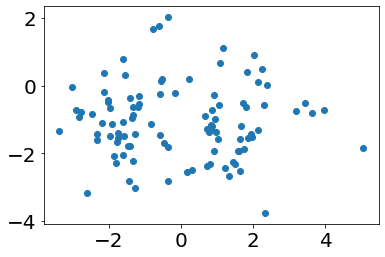

 62%|██████▏   | 3101/5000 [03:20<02:49, 11.19it/s]

Current lr:  0.0006561000000000001
On batch number 3100 ELBO is -10.701447486877441
On batch number 3100 Best ELBO is -7.238753318786621


 64%|██████▍   | 3199/5000 [03:27<02:03, 14.61it/s]

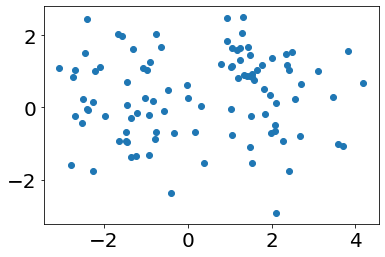

 64%|██████▍   | 3203/5000 [03:27<02:19, 12.86it/s]

Current lr:  0.0006561000000000001
On batch number 3200 ELBO is -8.580578804016113
On batch number 3200 Best ELBO is -7.238753318786621


 66%|██████▌   | 3299/5000 [03:34<01:58, 14.41it/s]

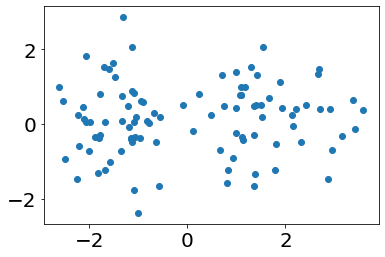

 66%|██████▌   | 3303/5000 [03:34<02:12, 12.78it/s]

Current lr:  0.00059049
On batch number 3300 ELBO is -8.311057090759277
On batch number 3300 Best ELBO is -7.238753318786621


 68%|██████▊   | 3399/5000 [03:41<01:49, 14.68it/s]

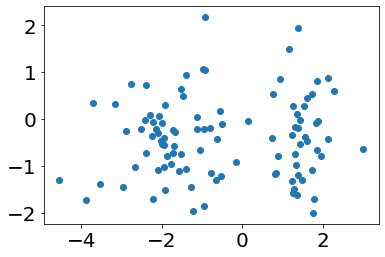

 68%|██████▊   | 3403/5000 [03:41<02:10, 12.22it/s]

Current lr:  0.00059049
On batch number 3400 ELBO is -8.421813011169434
On batch number 3400 Best ELBO is -7.07391357421875


 70%|██████▉   | 3499/5000 [03:48<01:43, 14.48it/s]

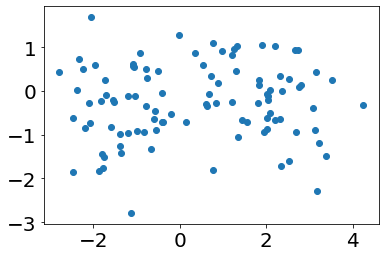

 70%|███████   | 3503/5000 [03:48<02:00, 12.47it/s]

Current lr:  0.00059049
On batch number 3500 ELBO is -8.61457347869873
On batch number 3500 Best ELBO is -7.07391357421875


 72%|███████▏  | 3599/5000 [03:55<01:37, 14.32it/s]

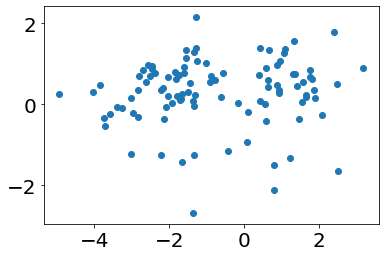

 72%|███████▏  | 3603/5000 [03:55<01:52, 12.44it/s]

Current lr:  0.000531441
On batch number 3600 ELBO is -8.207901000976562
On batch number 3600 Best ELBO is -7.07391357421875


 74%|███████▍  | 3699/5000 [04:02<01:30, 14.37it/s]

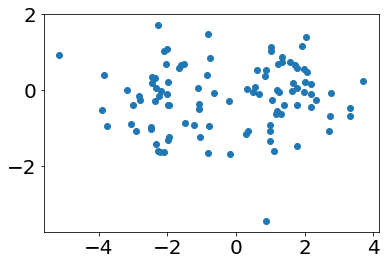

 74%|███████▍  | 3703/5000 [04:02<01:50, 11.79it/s]

Current lr:  0.000531441
On batch number 3700 ELBO is -8.248446464538574
On batch number 3700 Best ELBO is -7.07391357421875


 76%|███████▌  | 3799/5000 [04:09<01:23, 14.44it/s]

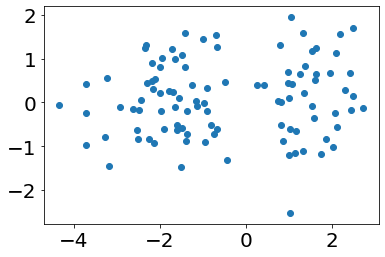

 76%|███████▌  | 3803/5000 [04:09<01:35, 12.56it/s]

Current lr:  0.0004782969
On batch number 3800 ELBO is -9.59010124206543
On batch number 3800 Best ELBO is -7.07391357421875


 78%|███████▊  | 3899/5000 [04:16<01:15, 14.66it/s]

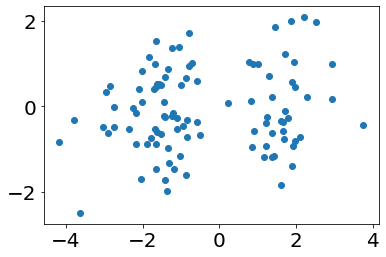

 78%|███████▊  | 3903/5000 [04:16<01:27, 12.52it/s]

Current lr:  0.0004782969
On batch number 3900 ELBO is -8.109365463256836
On batch number 3900 Best ELBO is -7.07391357421875


 80%|███████▉  | 3999/5000 [04:23<01:09, 14.38it/s]

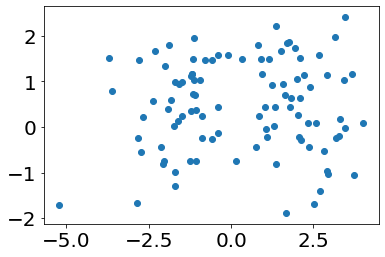

 80%|████████  | 4003/5000 [04:23<01:18, 12.68it/s]

Current lr:  0.00043046721
On batch number 4000 ELBO is -8.135624885559082
On batch number 4000 Best ELBO is -7.07391357421875


 82%|████████▏ | 4099/5000 [04:30<01:01, 14.58it/s]

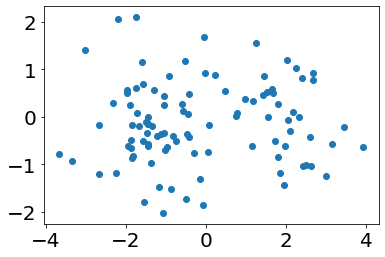

 82%|████████▏ | 4103/5000 [04:30<01:12, 12.40it/s]

Current lr:  0.00043046721
On batch number 4100 ELBO is -8.911535263061523
On batch number 4100 Best ELBO is -7.07391357421875


 84%|████████▍ | 4199/5000 [04:37<00:56, 14.29it/s]

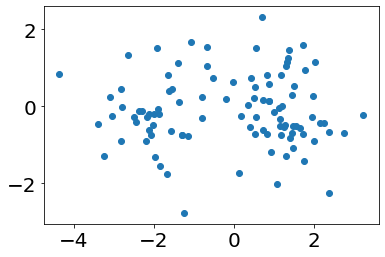

 84%|████████▍ | 4203/5000 [04:38<01:06, 12.04it/s]

Current lr:  0.000387420489
On batch number 4200 ELBO is -8.521413803100586
On batch number 4200 Best ELBO is -7.07391357421875


 86%|████████▌ | 4299/5000 [04:44<00:47, 14.73it/s]

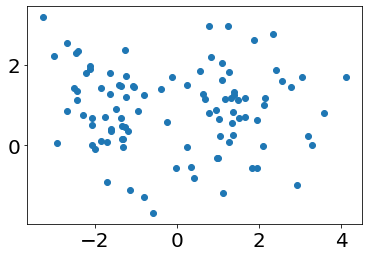

 86%|████████▌ | 4303/5000 [04:45<00:54, 12.77it/s]

Current lr:  0.000387420489
On batch number 4300 ELBO is -10.362836837768555
On batch number 4300 Best ELBO is -7.01765251159668


 88%|████████▊ | 4399/5000 [04:51<00:41, 14.63it/s]

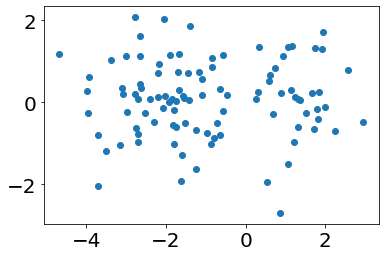

 88%|████████▊ | 4403/5000 [04:52<00:47, 12.61it/s]

Current lr:  0.000387420489
On batch number 4400 ELBO is -7.69585657119751
On batch number 4400 Best ELBO is -7.01765251159668


 90%|████████▉ | 4499/5000 [04:58<00:34, 14.56it/s]

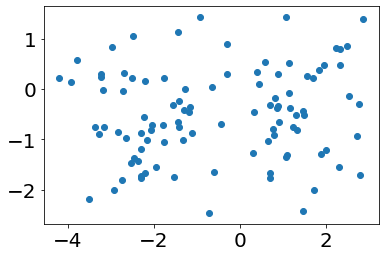

 90%|█████████ | 4503/5000 [04:59<00:39, 12.44it/s]

Current lr:  0.0003486784401
On batch number 4500 ELBO is -8.856325149536133
On batch number 4500 Best ELBO is -7.01765251159668


 92%|█████████▏| 4599/5000 [05:05<00:28, 14.30it/s]

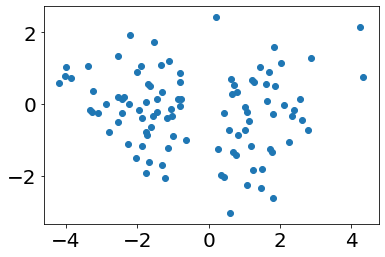

 92%|█████████▏| 4603/5000 [05:06<00:31, 12.70it/s]

Current lr:  0.0003486784401
On batch number 4600 ELBO is -8.94460391998291
On batch number 4600 Best ELBO is -7.01765251159668


 94%|█████████▍| 4699/5000 [05:12<00:20, 14.53it/s]

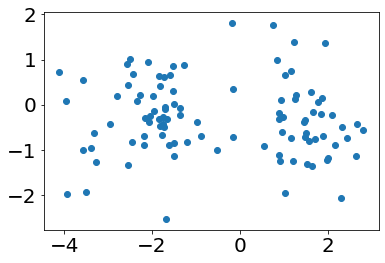

 94%|█████████▍| 4703/5000 [05:13<00:23, 12.64it/s]

Current lr:  0.00031381059609000004
On batch number 4700 ELBO is -8.448507308959961
On batch number 4700 Best ELBO is -7.01765251159668


 96%|█████████▌| 4799/5000 [05:19<00:12, 16.50it/s]

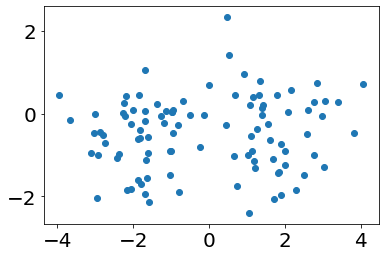

 96%|█████████▌| 4803/5000 [05:20<00:14, 13.42it/s]

Current lr:  0.00031381059609000004
On batch number 4800 ELBO is -8.229817390441895
On batch number 4800 Best ELBO is -7.01765251159668


 98%|█████████▊| 4899/5000 [05:25<00:06, 16.36it/s]

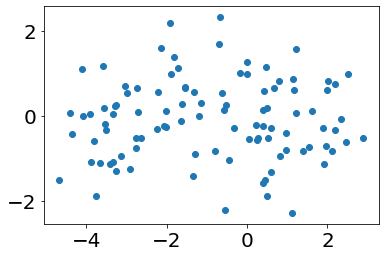

 98%|█████████▊| 4903/5000 [05:26<00:06, 13.98it/s]

Current lr:  0.00028242953648100003
On batch number 4900 ELBO is -9.523249626159668
On batch number 4900 Best ELBO is -7.01765251159668


100%|██████████| 5000/5000 [05:32<00:00, 15.05it/s]


In [7]:
print_info_ = 100
torch_log_2 = torch.tensor(np.log(2.), device=args.device, dtype=args.torchType)
best_elbo = -float("inf")

x_lim = limit
y_lim = limit

def compute_loss(q_new, p_new, q_old, p_old, sum_log_alpha, sum_log_jac, all_directions=None):
#     pdb.set_trace()
    if args.learnable_reverse:
        log_r = reverse_kernel(z_fin=q_new, a=all_directions)
    else:
        log_r = -args.K * torch_log_2
    log_p = target.get_logdensity(z=q_new) + args.std_normal.log_prob(p_new).sum(1)
    log_m = args.std_normal.log_prob(q_old).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac + sum_log_alpha
    elbo_full = log_p + log_r - log_m
    grad_elbo = torch.mean(elbo_full + elbo_full.detach() * sum_log_alpha)
    return elbo_full.detach().mean().item(), grad_elbo


iterator = tqdm(range(args.num_batches))
cur_tolerance = 0
for batch_num in iterator:
    plt.close()
    cond_vectors = [args.std_normal.sample((args.z_dim, )) for k in range(args.K)]
        
    # sample initial q and p
    q_old = args.std_normal.sample((args.train_batch_size, args.z_dim)).requires_grad_(True)
    p_old = args.std_normal.sample((args.train_batch_size, args.z_dim))
    
    # prepare tensors for auxilary stuff
    sum_log_alpha = torch.zeros(q_old.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
    sum_log_jacobian = torch.zeros(q_old.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
    
    q = q_old
    p = p_old
    if (batch_num) % print_info_ == 0:
        array_z = []
        array_directions = []
        array_alpha = []
        array_prop = []
        
    if args.learnable_reverse:
        all_directions = torch.tensor([], device=args.device)
    else:
        all_directions = None
        
    # run training cycle
    for k in range(args.K):
        q, p, log_jac, current_log_alphas, directions, q_prop = transitions[k].make_transition(q_old=q,
                                                    p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
#         if (batch_num) % print_info_ == 0:
#             print('On batch number {} and on k = {} we have for 0: {} and for +1: {}'.format(batch_num, k + 1,
#                                                         (directions==0.).to(float).mean(), (directions==1.).to(float).mean()))
#             print('Step size for {}-th transition is {}'.format(k, transitions[k].gamma.detach().exp()))
#             print('Alpha (ref) for {}-th transition is {}'.format(k, torch.sigmoid(transitions[k].alpha_logit.detach())))
        sum_log_alpha = sum_log_alpha + current_log_alphas
        sum_log_jacobian = sum_log_jacobian + log_jac
        if (batch_num) % print_info_ == 0:
            array_z.append(q.detach())
            array_directions.append(directions.detach())
            array_alpha.append(current_log_alphas.detach())
            array_prop.append(q_prop.detach())
        if args.learnable_reverse:
            all_directions = torch.cat([all_directions, directions.detach().view(-1, 1)], dim=1)
    elbo_full, grad_elbo = compute_loss(q_new=q, p_new=p, q_old=q_old, p_old=p_old, sum_log_jac=sum_log_jacobian,
                                            sum_log_alpha=sum_log_alpha, all_directions=all_directions)
    if (batch_num ) % print_info_ == 0:
        plt.scatter(q.cpu().detach()[:, 0], q.cpu().detach()[:, 1])
        plt.show();
        for param_group in optimizer.param_groups:
            current_lr = param_group['lr']
        print('Current lr: ', current_lr)
        print('On batch number {} ELBO is {}'.format(batch_num, elbo_full))
        print('On batch number {} Best ELBO is {}'.format(batch_num, best_elbo))
        
        fig, ax = plt.subplots(ncols=args.K, figsize=(30, 10))
        label = ['Same', 'Forward']
#         for kk in range(args.K):
#             ax[kk].scatter(array_prop[kk][:, 0].cpu().numpy(), array_prop[kk][:, 1].cpu().numpy(), color='r', label='Proposals')
#             for d in [0., 1.]:
#                 z_c = array_z[kk][array_directions[kk]==d]
#                 alpha_c = array_alpha[kk][array_directions[kk]==d].cpu().exp().numpy()
#                 color = np.zeros((z_c.shape[0], 4))
#                 color[:, 3] = alpha_c
#                 color[:, int(d + 1)] = 1.
#                 ax[kk].scatter(z_c[:, 0].cpu().numpy(), z_c[:, 1].cpu().numpy(), color=color, label=label[int(d)])
# #                 ax[kk].set_xlim((-x_lim, x_lim))
# #                 ax[kk].set_ylim((-y_lim, y_lim))
#                 ax[kk].legend()
#         plt.show();
    (-grad_elbo).backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step(elbo_full)

    if np.isnan(elbo_full):
        print('NAN appeared!')
        iterator.close()
        raise ValueError

    if elbo_full > best_elbo:
        best_elbo = elbo_full
        our_kernel.load_state_dict(transitions.state_dict())
        cur_tolerance = 0
    else:
        cur_tolerance += 1
        if cur_tolerance >= args.early_stopping_tolerance:
            print('Early stopping on {}'.format(batch_num))
            iterator.close()
            break

In [8]:
# our_kernel = transitions
for p in our_kernel.parameters():
    p.requires_grad_(False)

In [ ]:
# q_new = q_init
# p_new = p_init

# print("Now we are running warmup!")
# iterator = tqdm(range(args.n_warmup // args.K))
# for i in iterator:
#     q_new = q_new.detach().requires_grad_(True)
#     p_new = p_new.detach().requires_grad_(True)
#     for k in range(args.K):
#         cond_vectors = [args.std_normal.sample((args.z_dim, )) for _ in range(args.K)]
#         q_new, p_new, _, _, _, _ = our_kernel[k].make_transition(q_old=q_new, p_old=p_new, target_distr=target,
#                                                                    k=cond_vectors[k])
# iterator.close()
    
# samples_our = torch.empty((args.n_steps, args.n_chains, args.z_dim), device=args.device, dtype=args.torchType)
# print("Now we are sampling!")

# iterator = tqdm(range(args.n_steps // args.K))
# for i in iterator:
#     q_new = q_new.detach().requires_grad_(True)
#     p_new = p_new.detach().requires_grad_(True)
#     for k in range(args.K):
#         cond_vectors = [args.std_normal.sample((args.z_dim, )) for _ in range(args.K)]
#         q_new, p_new, _, _, a, _ = our_kernel[k].make_transition(q_old=q_new, p_old=p_new, target_distr=target,
#                                                                        k=cond_vectors[k])
#         samples_our[i] = q_new.detach()
# iterator.close()

In [ ]:
# target_samples = target.get_samples(n=1000).cpu().numpy()

# fig, ax = plt.subplots(nrows=args.n_chains // 5, ncols=5, figsize=(18, 7), dpi=300)
# plt.suptitle('HMC our')
# for chain_num in range(args.n_chains):
#     ax[chain_num // 5, chain_num % 5].scatter(target_samples[:, 0], target_samples[:, 1], c='r', label='Target')
#     ax[chain_num // 5, chain_num % 5].scatter(samples_our[:, chain_num, 0].cpu(), samples_our[:, chain_num, 1].cpu(), label='Result')
#     ax[chain_num // 5, chain_num % 5].set_xlim(-limit, limit)
#     ax[chain_num // 5, chain_num % 5].set_ylim(-limit, limit)
#     ax[chain_num // 5, chain_num % 5].set_aspect('equal')
#     ax[chain_num // 5, chain_num % 5].legend()
# plt.tight_layout();
# plt.subplots_adjust(left=0., right=1., bottom=0., top=0.9, wspace=0.1, hspace=0.15)

In [9]:
# n_samples = 10000
n_chains = 50
repetitions = 50

init_q = args.std_normal.sample((n_chains, args.z_dim)).requires_grad_(True)
q = init_q
our_samples = []
our_samples.append(q.cpu().detach().numpy())

# init_p = args.std_normal.sample((n_samples, args.z_dim))
# p = init_p

for rep in range(repetitions):
    init_p = args.std_normal.sample((n_chains, args.z_dim))
    p = init_p
    cond_vectors = [args.std_normal.sample((args.z_dim, )) for _ in range(args.K)]
    for k in range(args.K):
        q, p, _, _, _, _ = our_kernel[k].make_transition(q_old=q,
                                                    p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
        our_samples.append(q.cpu().detach().numpy())

In [10]:
our_samples = np.array(our_samples)

In [11]:
our_samples.shape

(251, 50, 2)

In [12]:
target_samples = target.get_samples(our_samples[:, 0, :].shape[0])

In [13]:
target_samples.shape

torch.Size([251, 2])

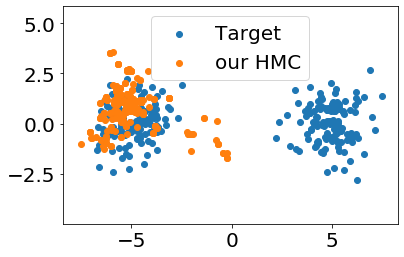

In [14]:
chain_ind = 19


plt.scatter(target_samples[:, 0].cpu().detach().numpy(), target_samples[:, 1].cpu().detach().numpy(), label='Target')
plt.scatter(our_samples[:, chain_ind, 0], our_samples[:, chain_ind, 1], label='our HMC')
# plt.xlim((-4, 4))
# plt.ylim((-4, 4))
plt.axis('equal')
plt.legend();
